In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import skimage as ski
import sns
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


## Data Handling

In [ ]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

In [ ]:
# Taking a number of data points from each class
def get_N_from_each_class(N, percentage_of_testing_data, x_train, y_train, x_test, y_test):
    # Generating indices for the data points we are going to take from the data (both test and train)
    selected_indices = []
    for class_label in range(10):
        # For every possible index, take the index iff the point belongs to this class 
        class_indices = [i for i in range(len(y_train)) if y_train[i][0] == class_label]
        selected_indices.append(class_indices[:N])

    # Picking the data based on the indices
    x_train = x_train[selected_indices]
    y_train = y_train[selected_indices]
    # Reshaping the data to flatten it to all classes together (to get it back to original form)
    x_train = x_train.reshape(-1, 32, 32, 3)
    y_train = y_train.reshape(-1, 1)

    # Doing the same with the test data
    selected_indices = []
    for class_label in range(10):
        class_indices = [i for i in range(len(y_test)) if y_test[i][0] == class_label]
        selected_indices.append(class_indices[:int(N * percentage_of_testing_data)])

    x_test = x_test[selected_indices]
    y_test = y_test[selected_indices]
    x_test = x_test.reshape(-1, 32, 32, 3)
    y_test = y_test.reshape(-1, 1)

    # Randomizing data, just in case
    # np.random.shuffle(x_train)
    # np.random.shuffle(y_train)
    # np.random.shuffle(x_test)
    # np.random.shuffle(y_test)

    indices = np.random.permutation(len(x_train))
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.random.permutation(len(x_test))
    x_test = x_test[indices]
    y_test = y_test[indices]

    return (x_train, y_train), (x_test, y_test)


n_samples_from_each_class = 70
(x_train, y_train), (x_test, y_test) = get_N_from_each_class(n_samples_from_each_class, 0.7, x_train, y_train, x_test,
                                                             y_test)

In [ ]:
# extrating the features from the images
# method used: Central Moments

def extract_image_features(image, C=3):
    '''
    Extracts the features from the image using the central moments method of order C
    It turns the image to grayscale, then calculates the central moments of order C
    
    Parameters:
    image: the image to be processed
    C: the moments order

    Returns:
    features: a vector of the features extracted from the image
    '''

    # turning the image to grayscale
    image = ski.color.rgb2gray(image)

    # calculating the central moments
    cal_moments = ski.measure.moments_central(image, order=C)

    # create an np array that contains zeroes 
    features = np.zeros(shape=int((C + 1) * (C + 2) / 2))

    # turn the 2D array to 1D by putting only the needed values based on this equation 
    # p + q <= C 
    # if C = 3 the needed numbers are : 00 01 10 11 20 02 21 12 03 30 , size = 10 s
    current = 0;
    for i in range(C + 1):
        for j in range(C + 1):
            if (i + j <= C):
                features[current] = cal_moments[i][j]
                current = current + 1

    return features



In [ ]:
#Display a sample of images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
    ax.set_title(f'Label: {y_train[i][0]}')

plt.tight_layout()
plt.show()


##### SVM 
<b>(An Example for Multi-Class Classification using SVM)</b>

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

- Here is what we going to do for the SVM:
    * We will use the SVM implementation in sklearn
    * The parameters of the SVM will be chosen using grid search with cross validation
        * Degree for the polynomial kernel
        * C parameter for the SVM
            * C (Regularization Parameter): The `C` parameter is a positive scalar that controls the regularization strength. It influences the optimization process by balancing the desire to fit the training data well against the goal of keeping the model simple and avoiding overfitting.
            * Smaller values of C result in a wider margin, allowing more training points to be misclassified.
            * Larger values of C result in a narrower margin, forcing the optimizer to classify all training points correctly.
        * Gamma parameter for `rbf` and `poly` kernels
        * we will use both OVR and OVO strategies (`decision_function_shape` parameter)
    
    * We will Grid Search to find the best parameters for the SVM
    * We will use the `make_pipeline` 
    * We will use the `StandardScaler` to scale the data 

In [ ]:
from sklearn.preprocessing import StandardScaler

C_order = 4
# Extracting the images features
Training_features = np.array([extract_image_features(x_train[i], C_order) for i in range(len(x_train))])
Testing_features = np.array([extract_image_features(x_test[i], C_order) for i in range(len(x_test))])

#standardize the data
standardized_training_features = StandardScaler().fit_transform(Training_features)
standardized_test_features = StandardScaler().fit_transform(Testing_features)

In [102]:
#Getting the optimal parameters using grid search
param = [
    {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 10],
     'kernel': ['rbf'],
     'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10, 100],
     'decision_function_shape': ['ovo', 'ovr']
     },
    {'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10, 100],
     'kernel': ['linear'],
     'decision_function_shape': ['ovo', 'ovr']
     },
    {'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10, 100],
     'kernel': ['poly'],
     'degree': [1, 2, 3, 4, 5, 10],
     'decision_function_shape': ['ovo', 'ovr']
     }
]

optimal_parameters_model = GridSearchCV(SVC(), param)
optimal_parameters_model.fit(standardized_training_features, y_train)
optimal_parameters = optimal_parameters_model.best_params_
optimal_parameters.setdefault('degree', 1)
optimal_parameters.setdefault('kernel', 'rbf')
optimal_parameters.setdefault('decision_function_shape', 'ovr')
optimal_parameters.setdefault('gamma', 0.001)
optimal_parameters.setdefault('C', 1)


C:\Users\GAMING\OneDrive\Desktop\SVMproject\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\GAMING\OneDrive\Desktop\SVMproject\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\GAMING\OneDrive\Desktop\SVMproject\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\GAMING\OneDrive\Desktop\SVMproject\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A colu

0.001

In [123]:

# Intiating the SVM classifier with a random state and the optimal parameters from the cross validation
SVMclassifier = SVC(random_state=42, kernel=optimal_parameters.get('kernel'), gamma=optimal_parameters.get('gamma'),
                    decision_function_shape=optimal_parameters.get('decision_function_shape'),
                    degree=optimal_parameters.get('degree'), C=optimal_parameters.get('C'))


In [124]:
#Training the classifier on the training data
SVMclassifier.fit(standardized_training_features, y_train)

C:\Users\GAMING\OneDrive\Desktop\SVMproject\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=100, decision_function_shape='ovo', degree=1, gamma=0.001,
    kernel='linear', random_state=42)

Correct: 124
Incorrect: 366


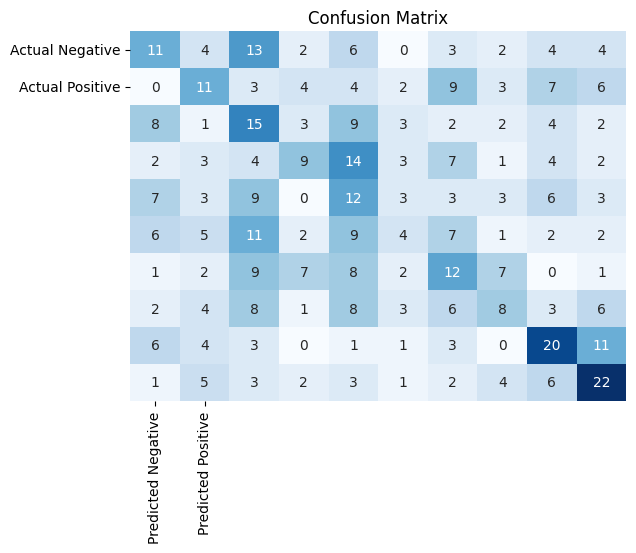

In [125]:
test_result = SVMclassifier.predict(standardized_test_features)
counter = 0
for i in range(len(test_result)):
    if test_result[i] == y_test[i]:
        counter += 1
print("Correct:", counter)
print("Incorrect:", len(test_result) - counter)
cm = confusion_matrix(y_test, test_result)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.show()

##### KNN 

( An Example for KNN Classification )

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

* The parameter we are going to experiment with the value of K (number of neighbors)
* The same thing as in SVM we are going to use `make_pipeline` and `StandardScaler` 